# CountGPVAE Simulation Demo

This notebook demonstrates how to use the modularized components of the CountGPVAE model.

In [1]:
import os
import pandas as pd
import geopandas as gpd
import jax
import jax.nn as nn
from jax import lax, random
import jax.numpy as jnp
from jax.random import PRNGKey
import numpy as np
import numpyro
import pickle
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, RenyiELBO
import arviz as az
import sys
from pyprojroot import here
import time
sys.path.append(str(here() / "simulation study" / "src"))
# Import our modular components
from kernels import exp_sq_kernel, M_g
from loader_jkt import load_data
from gp import gp_aggr
from vae import vae_model, vae_guide, vae_decoder
from plotting import plot_process, plot_incidence_map
import matplotlib.pyplot as plt
from numpyro.infer import NUTS, MCMC, Predictive, init_to_median, init_to_uniform, init_to_sample, init_to_mean, init_to_value

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MCMC Inference

## Load all the MCMC objects for all the years


In [ ]:
# for 2020, 2021, 2022, 2023
with open("../model weights/aggGP/mcmc_jkt_2021_30min_targetprob0.9_notconvergedyet.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggGP/mcmc_jkt_2021_36min_targetprob0.95.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

with open("../model weights/aggGP/mcmc_jkt_2021_38min_targetprob0.99.pkl", "rb") as f_3:
    mcmc_3 = pickle.load(f_3)

#with open("../model weights/aggGP/mcmc_jkt_2023_20min.pkl", "rb") as f_4:
    #mcmc_2023 = pickle.load(f_4)


In [27]:
n_lo = 1
n_hi = 5

# Yearly Inferences (Final)

### 2023 Inference

In [4]:
df_2023 = pd.read_csv("../data/processed/df_hi_jkt_w_pred_2023.csv")

In [5]:
import geopandas as gpd
from shapely import wkt

# If your CSV has a 'geometry' column in WKT format (i.e., POLYGON (...) as string)
df_2023['geometry'] = df_2023['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
gdf_2023 = gpd.GeoDataFrame(df_2023, geometry='geometry', crs="EPSG:4326")

In [6]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2023.get_samples()
print(mcmc_2023.print_summary())


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    102.97     11.73    102.36     87.25    123.88      8.91      1.26
          b_hdi      0.03      0.93      0.13     -1.47      1.64    323.39      1.01
  b_pop_density      0.30      1.21      0.18     -1.24      2.53      8.81      1.28
        b_urban      0.10      0.97      0.20     -1.50      1.55     76.92      1.06
  kernel_length      0.50      0.29      0.45      0.17      0.79    295.50      1.02
     kernel_var      0.37      0.02      0.37      0.34      0.40     32.14      1.09
       log_f[0]      2.85      0.53      2.85      1.99      3.79     40.70      1.10
       log_f[1]      2.87      0.52      2.90      1.92      3.71     39.57      1.10
       log_f[2]      2.86      0.52      2.89      1.98      3.74     38.36      1.10
       log_f[3]      2.89      0.52      2.96      1.99      3.74     36.55      1.12
       log_f[4]      2.84      0.51      2.82      2.

In [7]:
ss = numpyro.diagnostics.summary(mcmc_2023.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 12
Average ESS for all aggGP-low effects : 11
Max r_hat for all aggGP-low : 1.159999966621399
Average ESS for all aggGP-high effects : 12
Max r_hat for all aggGP-high : 1.159999966621399


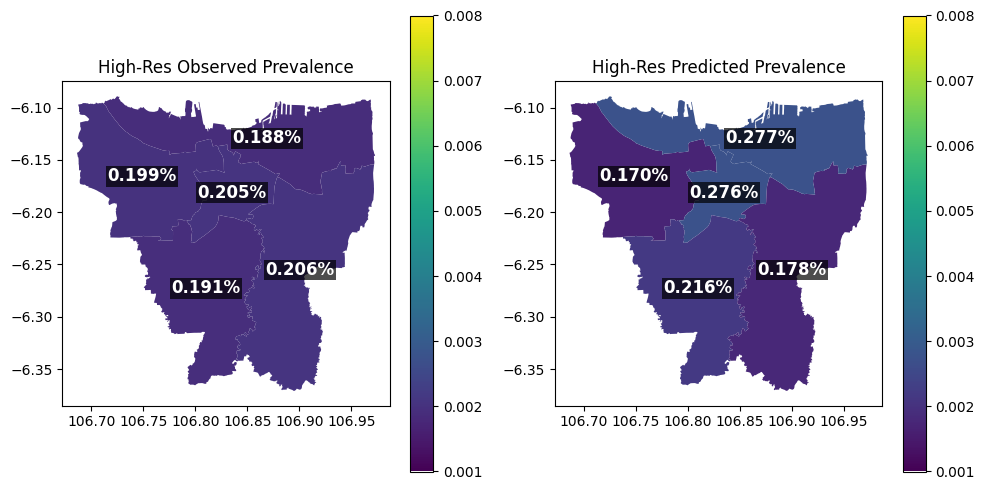

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(gdf_2023, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(gdf_2023, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

### 2022 Inference

In [9]:
df_2022 = pd.read_csv("../data/processed/df_hi_jkt_w_pred_2022.csv")

In [10]:
import geopandas as gpd
from shapely import wkt

# If your CSV has a 'geometry' column in WKT format (i.e., POLYGON (...) as string)
df_2022['geometry'] = df_2022['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry='geometry', crs="EPSG:4326")

In [11]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2022.get_samples()
print(mcmc_2022.print_summary())


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     98.63     10.05     98.07     81.28    113.77    138.25      1.04
          b_hdi     -0.09      0.95     -0.10     -1.54      1.52    360.36      1.02
  b_pop_density     -0.04      1.02     -0.01     -1.84      1.54     99.61      1.05
        b_urban      0.09      1.11      0.03     -1.56      2.03     34.75      1.09
  kernel_length      0.48      0.28      0.41      0.17      0.80    520.07      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40    974.92      1.01
       log_f[0]      2.99      0.60      2.96      2.13      3.97     23.40      1.18
       log_f[1]      2.97      0.57      2.98      2.10      3.86     32.33      1.13
       log_f[2]      2.96      0.58      2.93      2.09      3.88     18.58      1.18
       log_f[3]      2.95      0.57      2.92      2.08      3.85     26.83      1.14
       log_f[4]      2.96      0.58      2.95      2.

In [12]:
ss = numpyro.diagnostics.summary(mcmc_2022.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 32
Average ESS for all aggGP-low effects : 30
Max r_hat for all aggGP-low : 1.1200000047683716
Average ESS for all aggGP-high effects : 32
Max r_hat for all aggGP-high : 1.1399999856948853


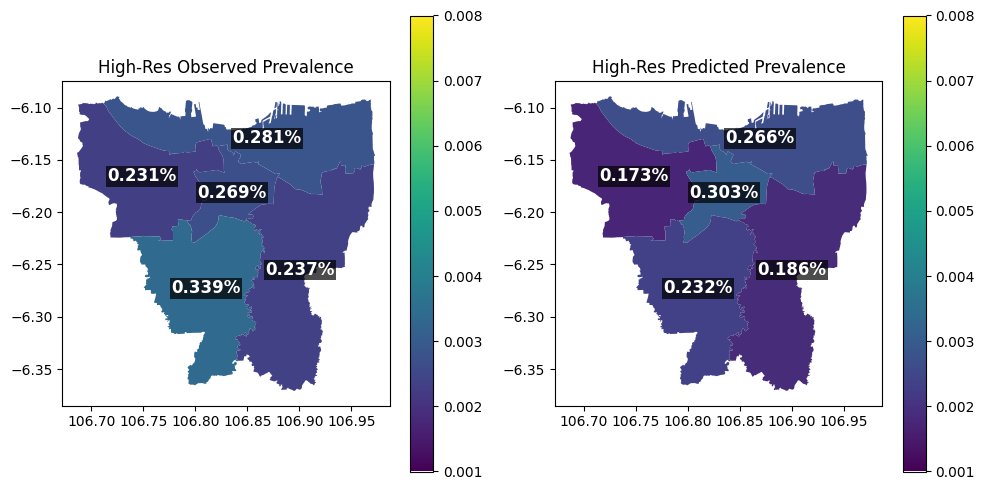

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(gdf_2022, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(gdf_2022, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

### 2021 Inference

In [14]:
df_2021 = pd.read_csv("../data/processed/df_hi_jkt_w_pred_2021.csv")

In [15]:
import geopandas as gpd
from shapely import wkt

# If your CSV has a 'geometry' column in WKT format (i.e., POLYGON (...) as string)
df_2021['geometry'] = df_2021['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry='geometry', crs="EPSG:4326")

In [16]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2021.get_samples()
print(mcmc_2021.print_summary())


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     96.05     10.84     96.80     82.73    113.75      4.95      1.33
          b_hdi     -0.52      1.10     -0.65     -2.57      1.16      8.10      1.40
  b_pop_density     -0.12      0.92     -0.27     -1.44      1.37     10.13      1.17
        b_urban     -0.07      0.81      0.08     -1.39      1.35    205.38      1.02
  kernel_length      0.47      0.26      0.37      0.18      0.74     16.23      1.11
     kernel_var      0.38      0.02      0.38      0.35      0.41     12.44      1.24
       log_f[0]      3.17      0.51      3.07      2.43      4.06      7.08      1.24
       log_f[1]      3.15      0.55      3.07      2.42      4.05      4.91      1.36
       log_f[2]      3.20      0.50      3.08      2.41      4.03      6.67      1.26
       log_f[3]      3.08      0.55      3.10      2.39      3.98      4.17      1.43
       log_f[4]      3.12      0.54      3.10      2.

In [17]:
ss = numpyro.diagnostics.summary(mcmc_2021.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 3
Average ESS for all aggGP-low effects : 3
Max r_hat for all aggGP-low : 1.8300000429153442
Average ESS for all aggGP-high effects : 3
Max r_hat for all aggGP-high : 1.8300000429153442


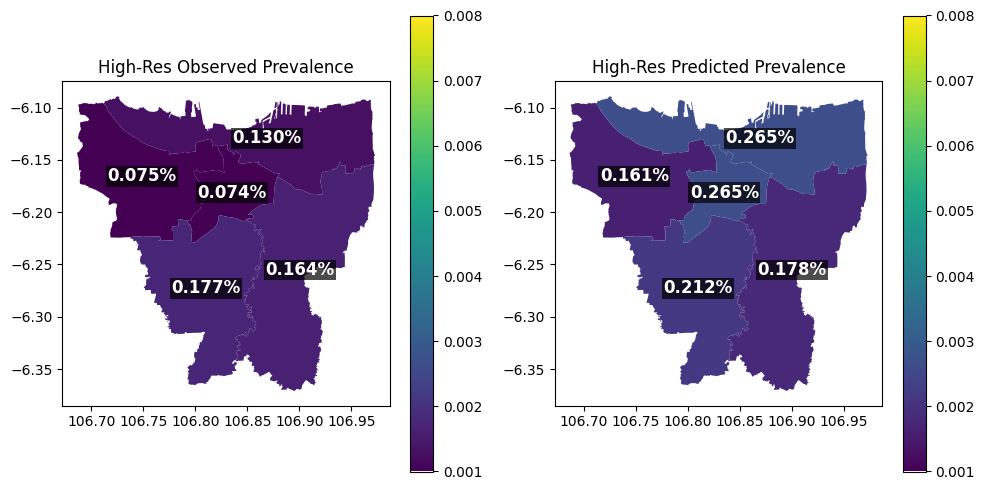

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(gdf_2021, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(gdf_2021, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

### 2020 Inference

In [19]:
df_2020 = pd.read_csv("../data/processed/df_hi_jkt_w_pred_2020.csv")

In [20]:
import geopandas as gpd
from shapely import wkt

# If your CSV has a 'geometry' column in WKT format (i.e., POLYGON (...) as string)
df_2020['geometry'] = df_2020['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry='geometry', crs="EPSG:4326")

In [21]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2020.get_samples()
print(mcmc_2020.print_summary())


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     99.74     10.39     99.63     83.27    116.01    103.55      1.04
          b_hdi     -0.04      0.93     -0.04     -1.61      1.46    489.42      1.01
  b_pop_density     -0.00      0.99     -0.00     -1.73      1.58    197.40      1.02
        b_urban     -0.08      0.93     -0.06     -1.54      1.52    160.50      1.03
  kernel_length      0.46      0.24      0.39      0.17      0.75    307.66      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40    312.07      1.02
       log_f[0]      2.98      0.56      3.05      1.95      3.76     64.17      1.09
       log_f[1]      3.00      0.56      3.06      2.01      3.77     55.41      1.09
       log_f[2]      3.00      0.55      3.06      2.12      3.82     54.75      1.10
       log_f[3]      2.97      0.53      3.02      2.12      3.78     59.79      1.08
       log_f[4]      2.97      0.51      3.04      2.

In [22]:
ss = numpyro.diagnostics.summary(mcmc_2020.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 59
Average ESS for all aggGP-low effects : 55
Max r_hat for all aggGP-low : 1.1299999952316284
Average ESS for all aggGP-high effects : 59
Max r_hat for all aggGP-high : 1.149999976158142


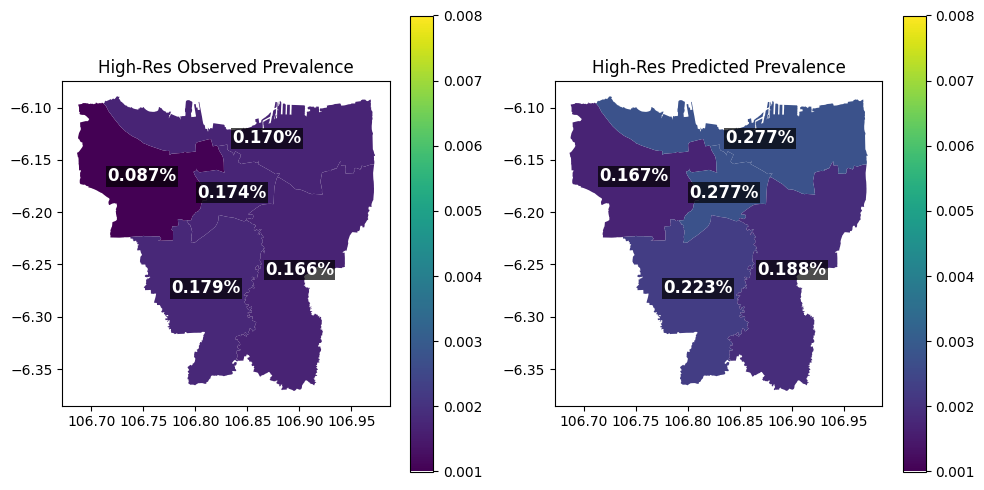

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(gdf_2020, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(gdf_2020, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()